*ANALYSIS PERFORMANCE*
Analysis in progress please wait...
Analysis completed in 985s. Printing results.

*RESULTS*
Mean crack length at failure (l) = 1.806638 mm with standard deviation = 0.037171
Mean remote stress at failure (σ_inf) = 383.293720 MPa with standard deviation = 0.037171

*COMPARING OUTPUT DISTRIBUTIONS TO A NORMAL DISTRIBUTION (D’AGOSTINO-PEARSON TEST FOR NORMALITY)*
Null hypothesis: l and σ_inf come from a normal distribution (alpha = 0.05)
l: statistic = 0.782963, p-value = 0.676055
--> The null hypothesis cannot be rejected (p > alpha)
σ_inf: statistic = 2.2783, p-value = 0.320091
--> The null hypothesis cannot be rejected (p > alpha)


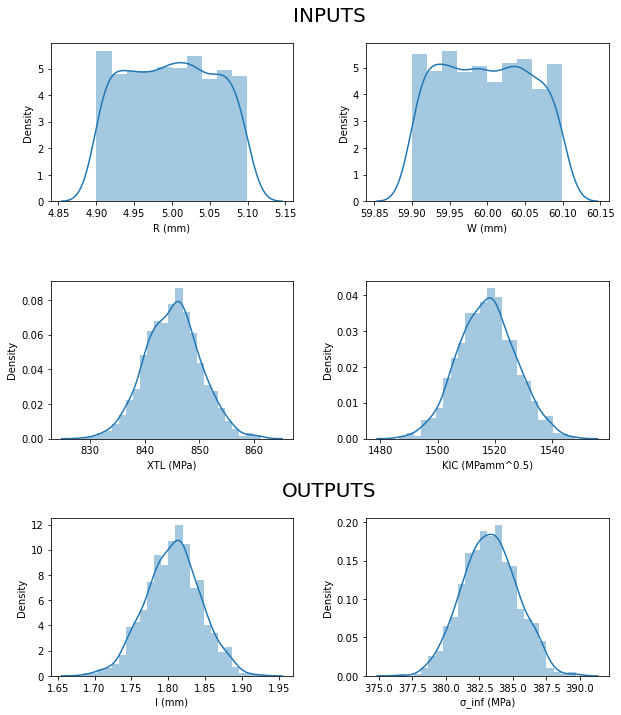

In [2]:
# Imports
import mpmath
import time
import itertools
import numpy as np
import sympy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sympy import nsolve
from sympy.solvers import solve
from scipy import stats

# Starting run timer and printing running message
start = time.time()
print("*ANALYSIS PERFORMANCE*")
print("Analysis in progress please wait...")

# Inputs
# Distributed geometric inputs
size = 1000  # Number of samples
R_values = np.random.uniform(4.9, 5.1, size)  # (mm)
W_values = np.random.uniform(59.9, 60.1, size)  # R/W must be < 1/2

# Distributed mechanical properties (loc=mean value, scale=standard deviation, size=number of samples)
XTL_obj = stats.norm(loc=845.1, scale=5)
XTL_values = XTL_obj.rvs(size=size)  # (MPa) unnotched strength of the laminate
KIC_obj = stats.norm(loc=1517, scale=10)
KIC_values = KIC_obj.rvs(size=size)  # (MPamm^0.5) mode I fracture toughness of the laminate

# Elastic properties
E1 = 171400  # (MPa)
E2 = 9100  # (MPa)
G12 = 5300  # (MPa)
v12 = 0.3
v21 = E2*(v12/E1)

# Ply parameters
number_of_plies = 24
ply_thickness = [0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002]  # (m) Enter value for each ply
ply_angle = [90, 0, 45, -45, -45, 45, 0, 90, 90, 0, 45, -45, -45, 45, 0, 90, 90, 0, 45, -45, -45, 45, 0, 90]  # Enter value for each ply

# Checking for input errors
if len(ply_angle) != number_of_plies:
    print("Error. Please enter angle of every ply")
    exit()

if len(ply_thickness) != number_of_plies:
    print("Error. Please enter thickness of every ply")
    exit()

# Adding standard deviation to ply angles
ply_angle_lists = []
for i in range(size):
    ply_sd_obj = stats.norm(loc=0, scale=1)
    ply_sd_list = ply_sd_obj.rvs(size=number_of_plies)
    ply_angle_list = [sum(angle) for angle in zip(ply_angle, ply_sd_list)]
    ply_angle_lists.append(ply_angle_list)

# Calculating Aij components of the laminate in-plane stiffness
# Creating empty lists for for loop stiffness outputs
A11_list = []
A12_list = []
A21_list = []
A22_list = []
A66_list = []

# Calculating list of trigonometric values, where m = cosθ and n = sinθ
for ply_angle in ply_angle_lists:
    m_values = []
    n_values = []
    for i in range(number_of_plies):
        m = np.cos(np.radians(ply_angle[i]))
        m_values.append(m)
        n = np.sin(np.radians(ply_angle[i]))
        n_values.append(n)

    # Calculating Q values (constant for every ply)
    Q11 = E1/(1-(v12*v21))
    Q12 = (v21*E1)/(1-(v12*v21))
    Q21 = (v12*E2)/(1-(v12*v21))
    Q22 = E2/(1-(v12*v21))
    Q66 = G12

    # Calculating Qbar values (different for every ply: depends on ply orientation)
    Qbar11_values = []
    Qbar12_values = []
    Qbar21_values = []
    Qbar22_values = []
    Qbar66_values = []

    for i in range(number_of_plies):
        Qbar11 = ((m_values[i]**4)*Q11)+((n_values[i]**4)*Q22)+((2*(m_values[i]**2)*(n_values[i]**2))*Q12)+((4*(m_values[i]**2)*(n_values[i]**2))*Q66)
        Qbar11_values.append(Qbar11)
        Qbar12 = (((m_values[i]**2)*(n_values[i]**2))*Q11)+(((m_values[i]**2)*(n_values[i]**2))*Q22)+((m_values[i]**4)*Q12)+((-4*(m_values[i]**2)*(n_values[i]**2))*Q66)
        Qbar12_values.append(Qbar12)
        Qbar21 = (((m_values[i]**2)*(n_values[i]**2))*Q11)+(((m_values[i]**2)*(n_values[i]**2))*Q22)+(((m_values[i]**4)+(n_values[i]**4))*Q21)+((-4*(m_values[i]**2)*(n_values[i]**2))*Q12)
        Qbar21_values.append(Qbar21)
        Qbar22 = ((n_values[i]**4)*Q11)+((m_values[i]**4)*Q22)+((2*(m_values[i]**2)*(n_values[i]**2))*Q12)+((4*(m_values[i]**2)*(n_values[i]**2))*Q66)
        Qbar22_values.append(Qbar22)  
        Qbar66 = (((m_values[i]**2)*(n_values[i]**2))*Q11)+(((m_values[i]**2)*(n_values[i]**2))*Q22)+((-2*(m_values[i]**2)*(n_values[i]**2))*Q12)+((((m_values[i]**2)-(n_values[i]**2))**2)*(Q66))
        Qbar66_values.append(Qbar66)

    # Calculating A values (components of the laminate in-plane stiffness matrix)
    A11_values = []
    A12_values = []
    A21_values = []
    A22_values = []
    A66_values = []

    for i in range(number_of_plies):
        A11 = Qbar11_values[i]*ply_thickness[i]
        A11_values.append(A11)
        A12 = Qbar12_values[i]*ply_thickness[i]
        A12_values.append(A12)
        A21 = Qbar21_values[i]*ply_thickness[i]
        A21_values.append(A21)
        A22 = Qbar22_values[i]*ply_thickness[i]
        A22_values.append(A22)
        A66 = Qbar11_values[i]*ply_thickness[i]
        A66_values.append(A66)

    A11 = sum(A11_values)
    A12 = sum(A12_values)
    A21 = sum(A21_values)
    A22 = sum(A22_values)
    A66 = sum(A66_values)
    
    # Appending stiffness values from each iteration to empty lists
    A11_list.append(A11)
    A12_list.append(A12)
    A21_list.append(A21)
    A22_list.append(A22)
    A66_list.append(A66)

# Creating empty lists for for loop outputs
l_values = []
σ_inf_values_list = []

# For loop to create distribution outputs
for R, W, XTL, KIC, A11, A12, A21, A22, A66 in zip(R_values, W_values, XTL_values, KIC_values, A11_list, A12_list, A21_list, A22_list, A66_list):

    # Calculate M (geometric parameter)
    M = np.sqrt((np.sqrt(1-8*((3*(1-2*(R/W)))/(2+(1-2*(R/W))**3)-1))-1)/(2*((2*(R/W))**2)))

    # Calculating KT∞
    KT_inf = 1 + np.sqrt((2/A22)*((np.sqrt(A11*A22))-A12+((A11*A22-(A12**2))/(2*A66))))

    # Calculating RK
    RK = ((3*(1-2*(R/W)))/(2+(1-2*(R/W))**3)+(0.5*((2*R*M)/W)**6)*(KT_inf-3)*(1-((2*R*M)/W)**2))**-1

    # Calculating fn
    a = sp.Symbol('a')
    fn = 1 + 0.358*(R/a) + 1.425*(R/a)**2 - 1.578*(R/a)**3 + 2.156*(R/a)**4

    # Calculating Fh
    Fh = sp.sqrt(1-(R/a))*fn

    # Calculating Fw
    Fw = sp.sqrt(sp.sec(mpmath.radians((np.pi*R)/W)) * sp.sec(mpmath.radians((np.pi*a)/W)))

    # Solving for l
    # Integrating denominator
    x = sp.Symbol('x')
    l = sp.Symbol('l')
    integral_d = sp.integrate((2 + (R/x)**2 + 3*(R/x)**4 - (KT_inf-3)*((5*(R/x)**6)-7*(R/x)**8)), 
                              (x, R, R+l))

    # Calculating denominator
    denom = RK**2*integral_d**2

    # Integrating numerator using the Simpson's Rule
    ul = R+l  # upper limit
    ll = R  # lower limit
    n = 10  # number of strips (must be even)
    h = (ul-ll)/n  # height of each strip
    f = ((Fh*Fw)**2)*a

    a_values = []
    for i in range(n+1):
        dh = ll + h*i
        a_values.append(dh)

    a_values_odd = a_values[1::2]  # creates list of only values in odd index positions
    a_values_even = a_values[2:n:2]  # creates list of only values in even index positions 
                                     # excluding first and last
    integral_n_odd_values = []
    for i in range(len(a_values_odd)):
        integral_n_odd = 4*(f.subs(a, a_values_odd[i]))
        integral_n_odd_values.append(integral_n_odd)

    integral_n_even_values = []
    for i in range(len(a_values_even)):
        integral_n_even = 2*(f.subs(a, a_values_even[i]))
        integral_n_even_values.append(integral_n_even)

    integral_n = (h/3)*(f.subs(a, a_values[0])+(f.subs(a, a_values[n]))+sum(integral_n_odd_values)+sum(integral_n_even_values))

    # Calculating numerator
    numer = 4*l*np.pi*integral_n

    # Calculating l
    l_equation = (numer/denom)-(KIC/XTL)**2
    l = nsolve(l_equation, l, (0, W-R))

    # Calculating stress distribution across x-axis
    σ_inf = sp.Symbol('σ_inf')
    σyy = ((RK*σ_inf)/2)*((2+(R/x)**2)+3*((R/x)**4)-((KT_inf-3)*((5*(R/x)**6)-(7*(R/x)**8))))

    # Integrating and calculating LHS of equation 1 to solve for σ_inf
    ul = R+l  # upper limit
    ll = R  # lower limit
    n = 10  # number of strips (must be even)
    h = (ul-ll)/n  # height of each strip
    f = ((RK*σ_inf)/2)*((2+(R/x)**2)+3*((R/x)**4)-((KT_inf-3)*((5*(R/x)**6)-(7*(R/x)**8))))

    x_values = []
    for i in range(n+1):
        dh = ll + h*i
        x_values.append(dh)

    x_values_odd = x_values[1::2]  # creates list of only values in odd index positions
    x_values_even = x_values[2:n:2]  # creates list of only values in even index positions 
                                     # excluding first and last
    integral_n_odd_values = []
    for i in range(len(x_values_odd)):
        integral_n_odd = 4*(f.subs(x, x_values_odd[i]))
        integral_n_odd_values.append(integral_n_odd)

    integral_n_even_values = []
    for i in range(len(x_values_even)):
        integral_n_even = 2*(f.subs(x, x_values_even[i]))
        integral_n_even_values.append(integral_n_even)

    integral_1 = (h/3)*(f.subs(x, x_values[0])+(f.subs(x, x_values[n]))+sum(integral_n_odd_values)+sum(integral_n_even_values))
    eq_1 = ((1/l)*integral_1)-XTL
    σ_inf = solve(eq_1, σ_inf)

    # Appending l and σ_inf from each iteration to the created lists
    l_values.append(l)
    σ_inf_values_list.append(σ_inf)
    σ_inf_values = list(itertools.chain(*σ_inf_values_list))  # Creating single list from 'list
                                                              # of lists'

# Showing input and output distributions and output mean results
end = time.time()
run_time = int(end-start)
print("Analysis completed in " + str(run_time) + "s. Printing results.\n")
        
# Finding the mean values and standard deviations of l and σ_inf from output distributions
l_values_mean = sum(l_values)/len(l_values)
σ_inf_values_mean = sum(σ_inf_values)/len(σ_inf_values)
l_values_sd = np.std(l_values, dtype=float)
σ_inf_values_sd = np.std(σ_inf_values, dtype=float)

print("*RESULTS*")
print("Mean crack length at failure (l) = " + str(round(l_values_mean,6))+ " mm with standard deviation = " + str(round(l_values_sd,6)))
print("Mean remote stress at failure (σ_inf) = " + str(round(σ_inf_values_mean,6))+ " MPa with standard deviation = " + str(round(l_values_sd,6)) + "\n")

# Comparing outputs to normal distribution
alpha = 0.05
l_stat, l_p = stats.normaltest(np.array(l_values, dtype='float64'))
σ_inf_stat, σ_inf_p = stats.normaltest(np.array(σ_inf_values, dtype='float64'))

print("*COMPARING OUTPUT DISTRIBUTIONS TO A NORMAL DISTRIBUTION (D’AGOSTINO-PEARSON TEST FOR NORMALITY)*")
print("Null hypothesis: l and σ_inf come from a normal distribution (alpha = " + str(alpha) + ")")

print("l: statistic = " + str(round(l_stat,6)) + ", p-value = " + str(round(l_p,6)))
if l_p < alpha:
    print("--> The null hypothesis can be rejected (p < alpha)")
else:
    print("--> The null hypothesis cannot be rejected (p > alpha)")

print("σ_inf: statistic = " + str(round(σ_inf_stat,6)) + ", p-value = " + str(round(σ_inf_p,6)))
if σ_inf_p < alpha:
    print("--> The null hypothesis can be rejected (p < alpha)")
else:
    print("--> The null hypothesis cannot be rejected (p > alpha)") 

# Plotting input and output distributions
plt.figure(figsize=(10, 16))

plt.subplot(4, 2, 1)
R_plot = sns.distplot(R_values)
R_plot.set(xlabel="R (mm)", ylabel="Density")
R_plot.set_title('INPUTS', x=1.15, y=1.1, fontsize=20)

plt.subplot(4, 2, 2)
W_plot = sns.distplot(W_values)
W_plot.set(xlabel="W (mm)", ylabel="Density")

plt.subplot(4, 2, 3)
XTL_plot = sns.distplot(XTL_values)
XTL_plot.set(xlabel="XTL (MPa)", ylabel="Density")

plt.subplot(4, 2, 4)
KIC_plot = sns.distplot(KIC_values)
KIC_plot.set(xlabel="KIC (MPamm^0.5)", ylabel="Density")

plt.subplot(4, 2, 5)
l_plot = sns.distplot(l_values)
l_plot.set(xlabel="l (mm)", ylabel="Density")
l_plot.set_title('OUTPUTS', x=1.15, y=1.1, fontsize=20)

plt.subplot(4, 2, 6)
σ_inf_plot = sns.distplot(σ_inf_values)
σ_inf_plot.set(xlabel="σ_inf (MPa)", ylabel="Density")

plt.subplots_adjust(hspace=0.5, wspace=0.3)           